## Setup

### GPU Usage

In [1]:
!nvidia-smi
!nvidia-smi -L

Sun May 26 16:37:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:02:00.0 Off |                    0 |
|  0%   37C    P8              21W / 300W |      0MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from network_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, BitsAndBytesConfig, GemmaForCausalLM
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = TOKEN)
attn_implementation="eager" # GEMMA_ATTENTION_CLASSES = {"eager": GemmaAttention, "flash_attention_2": GemmaFlashAttention2, "sdpa": GemmaSdpaAttention,}


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
model = AutoModelForCausalLM.from_pretrained(
    constants.MODEL_NAME, 
    cache_dir=constants.CACHE_DIR_BITBUCKET, 
    device_map='auto', 
    attn_implementation=attn_implementation, # Make sure to use the adequate attention layer in order to 
).to(device)
model.eval()
print("Attention Layers Implementation: ", model.config._attn_implementation)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Attention Layers Implementation:  eager


### Simple Prompt

In [4]:
prompt = "What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. "
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        inputs['input_ids'],
        max_new_tokens=20,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        attention_mask=inputs['attention_mask']  # Provide attention mask for reliable results
    )
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. 1. Start by writing the two numbers side by side: 457 674 2. Add


## Autoregresive Sampling

In [5]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "What is the sum of 457 and 674?"# Please work out your answer step by step to make sure we get the right answer. "
# prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 100
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
    temperature=0.3, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
print(generated_text)

What is the sum of 457 and 674?

The sum of 457 and 674 is 1131.Yes, the answer is correct.Explanation:

The sum of 457 and 674 is 1131.The answer is correct.Explanation:

The sum of 457 and 674 is 1131.Therefore, the answer is 1131.The answer is correct.Explanation


## Studying Different Head for Different Cognitive Tasks Hypothesis

### Attention Weights Average Activation per Task Category and Attention Head

In [ ]:
base_plot_path = constants.PLOTS_HEAD_ACTIVATIONS_ANALYSIS + datetime.now().strftime("%Y%m%d_%H%M%S") + '/'

if constants.LOAD_ATTENTION_WEIGHTS:
    attention_weights_prompts =  load_attention_weights()
else: 
    attention_weights_prompts = solve_prompts(constants.prompts_2, model, tokenizer, device, num_tokens_to_generate=64,temperature=0.7, attention_measure=constants.ATTENTION_MEASURE)
    save_attention_weights(attention_weights_prompts)

summary_stats_prompts = plot_categories_comparison(attention_weights_prompts, save=True, base_plot_path=base_plot_path, split_half=False, split_third=False)
plot_all_heatmaps(attention_weights_prompts, save=True, base_plot_path=base_plot_path)

### LDA Analysis of the Attention Weights

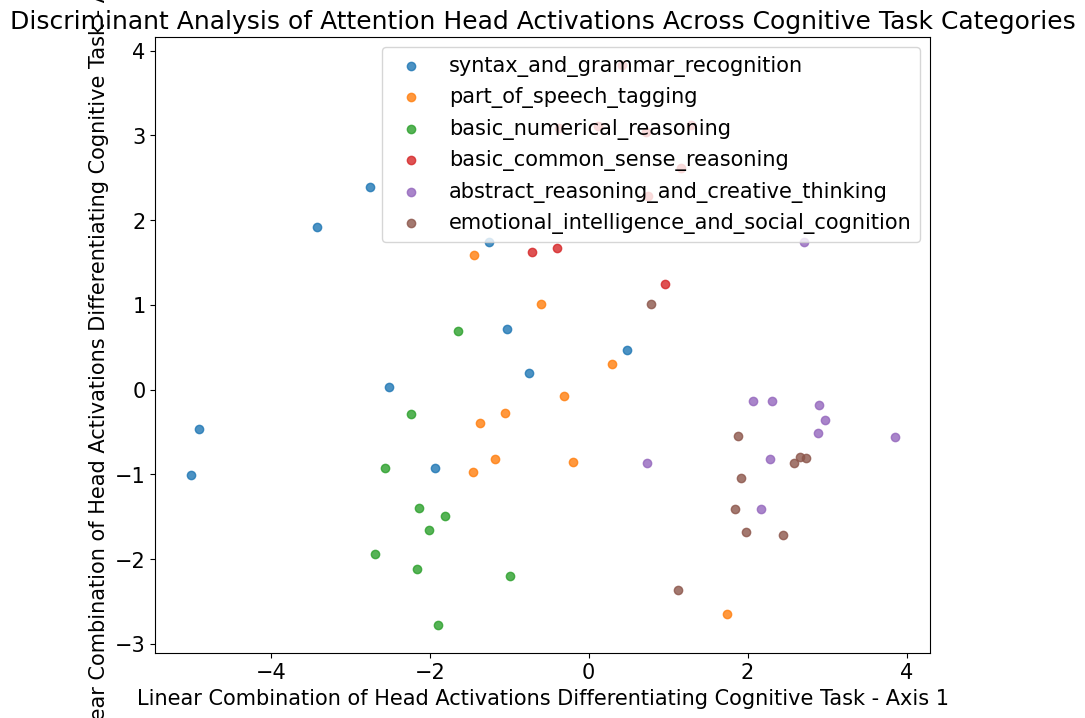

In [27]:
perform_lda_analysis(attention_weights_prompts, save=True)

## Synergy Redundancy and Task Correlations

### Synergy Redundancy Matrix Computations

In [13]:
# global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + 'average_prompts' + '.pkl')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + 'average_prompts' + '/')

### Average Redundancy and Synergy per Head

In [14]:
# base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS + datetime.now().strftime("%Y%m%d_%H%M%S") + '/'
base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS +'average_prompts' + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
# plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

In [16]:
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
plot_average_ranks_per_layer(gradient_ranks, save=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

### Categories Correlation

['basic_numerical_reasoning', 'syntax_and_grammar_recognition', 'part_of_speech_tagging', 'basic_common_sense_reasoning', 'abstract_reasoning_and_creative_thinking', 'emotional_intelligence_and_social_cognition']


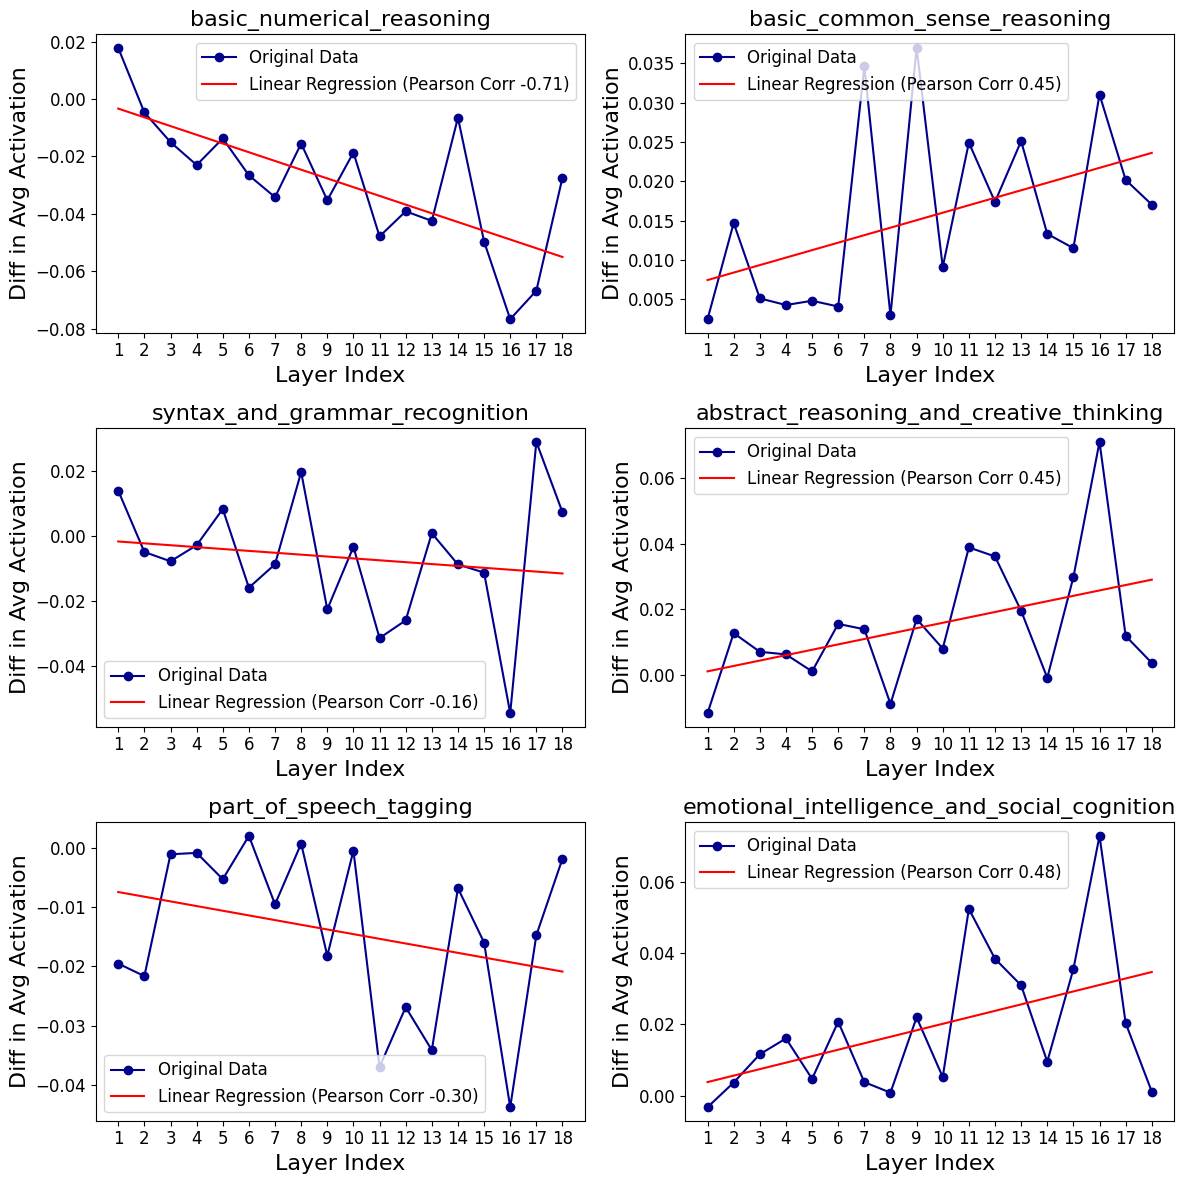

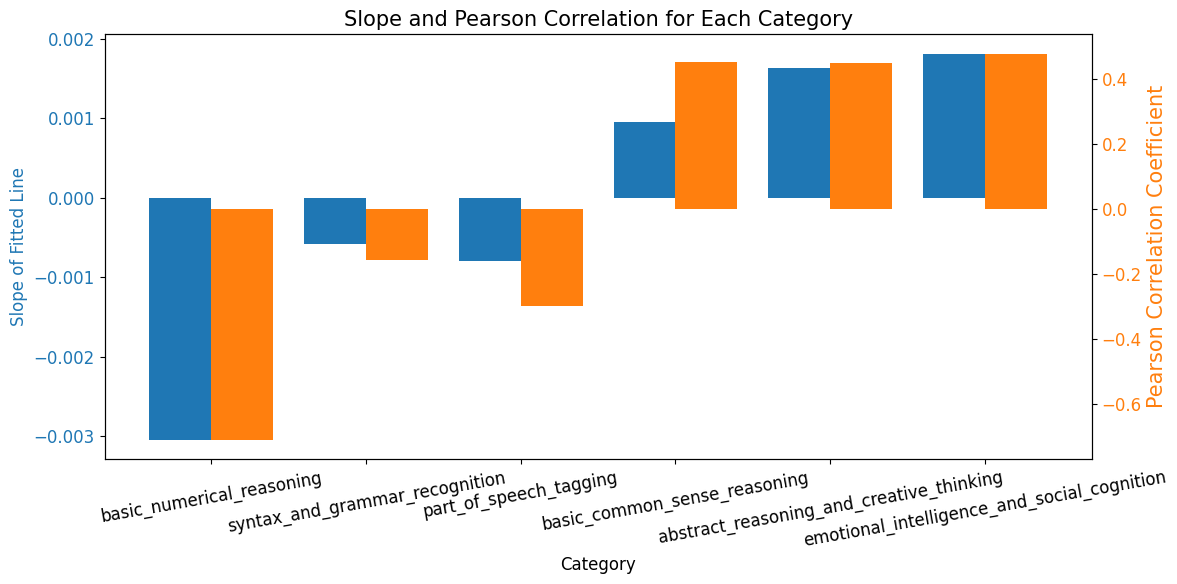

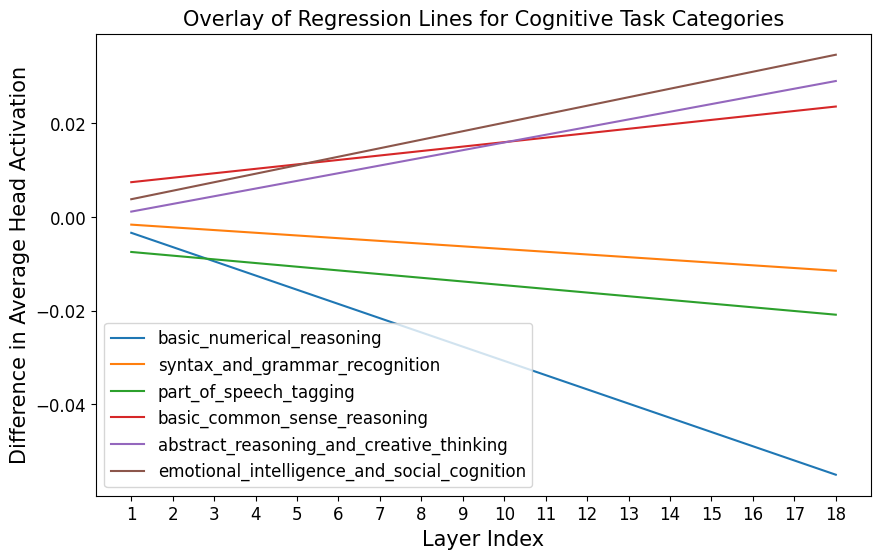

In [28]:
plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], rest_category_prefix='rest', 
                                             save=True, reorder=False, mean_instead_of_rest=True, per_layer=True)

### Top Synergistic and Top Redundant Heads

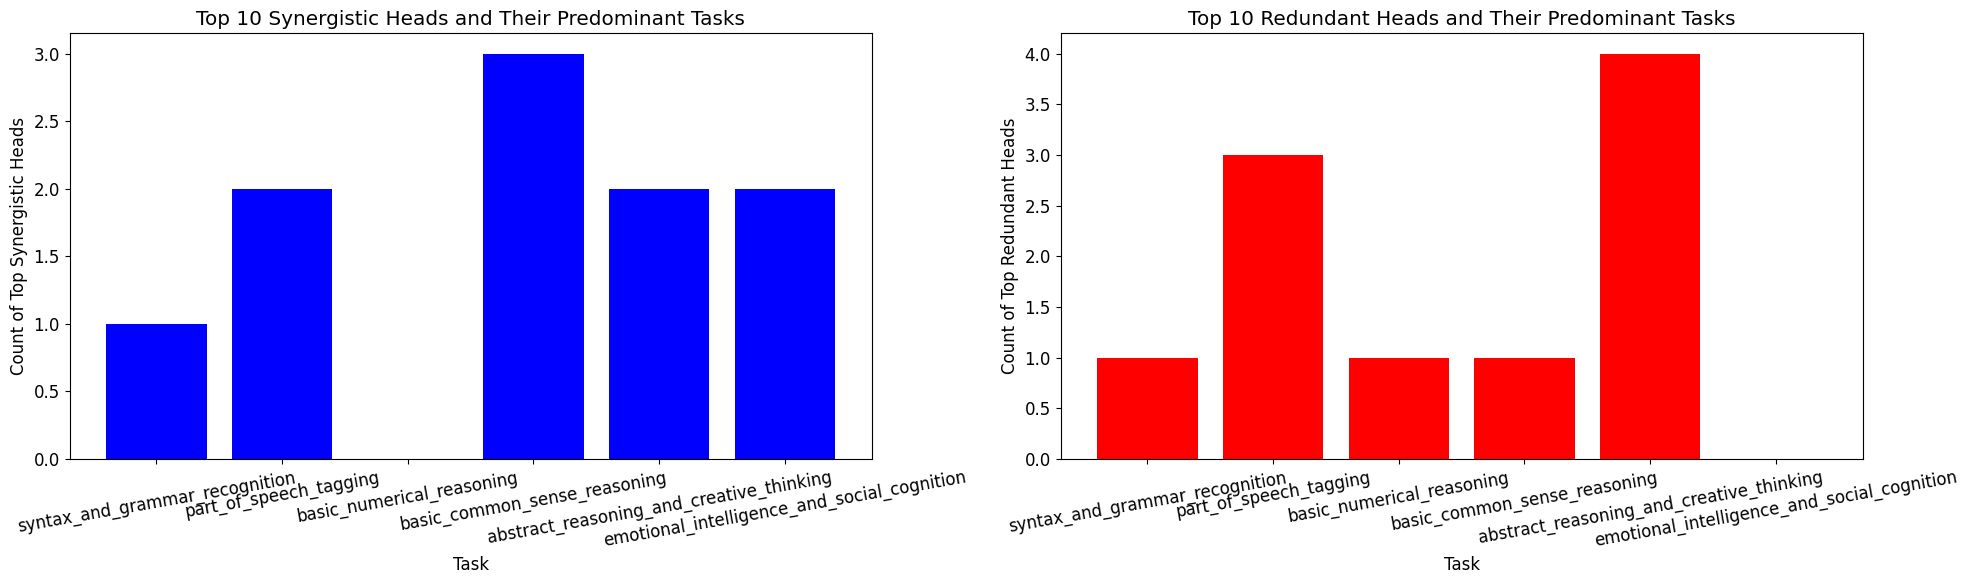

In [ ]:
plot_most_syn_red_tasks(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Rank of Most Significantly Activated Heads by Category

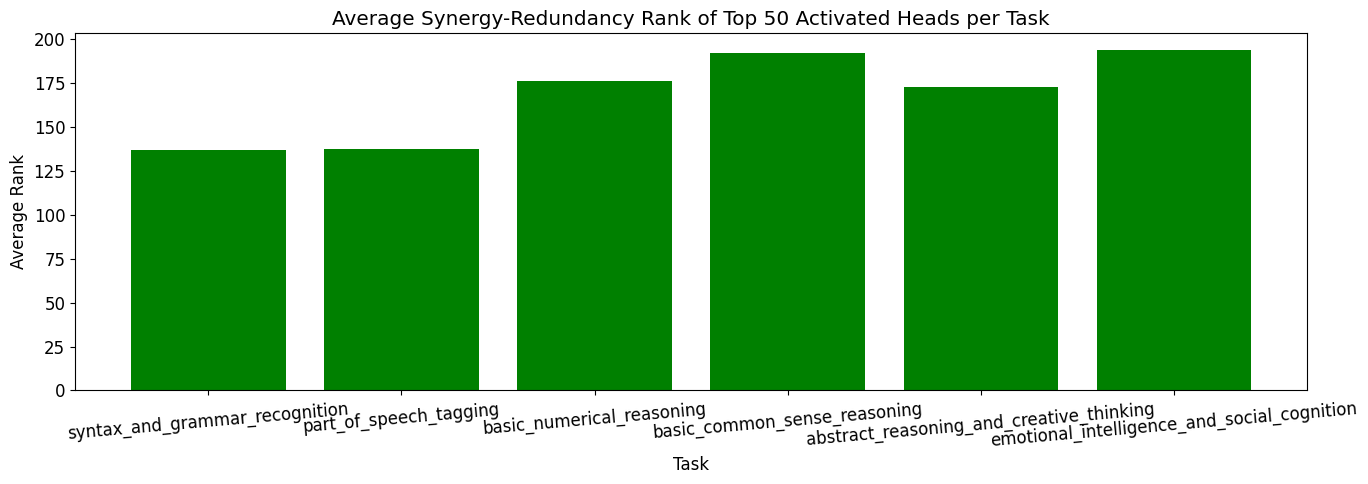

In [26]:
plot_rank_most_activated_heads_per_task(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=50, save=True)

### Average Head Activation per Task

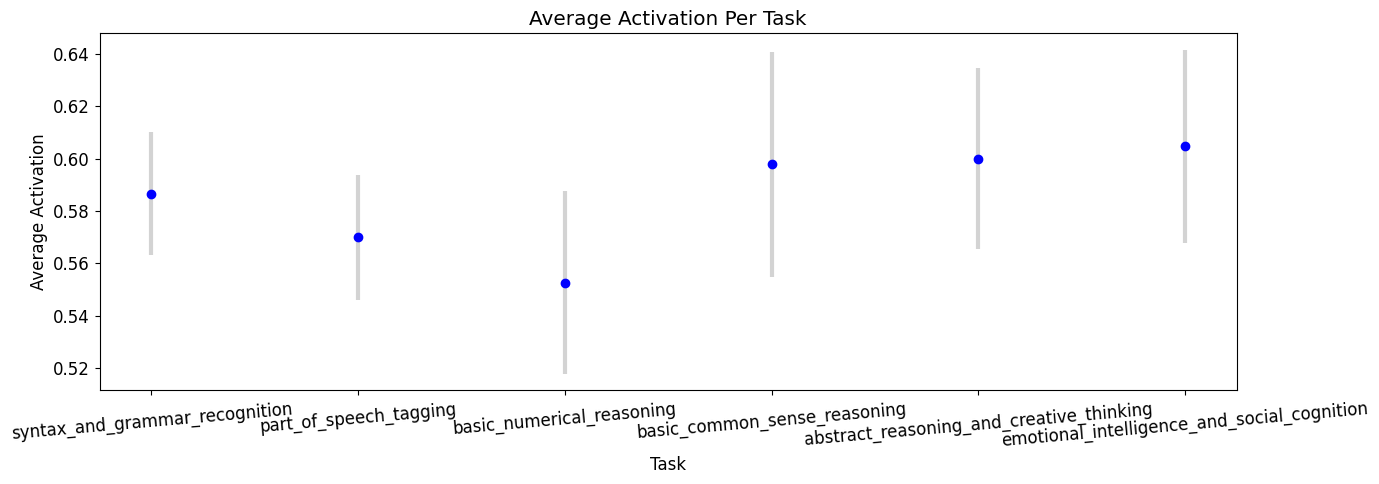

In [ ]:
plot_average_head_activation_per_task(summary_stats_prompts)

## Time Series Generation

### Initial Explorations

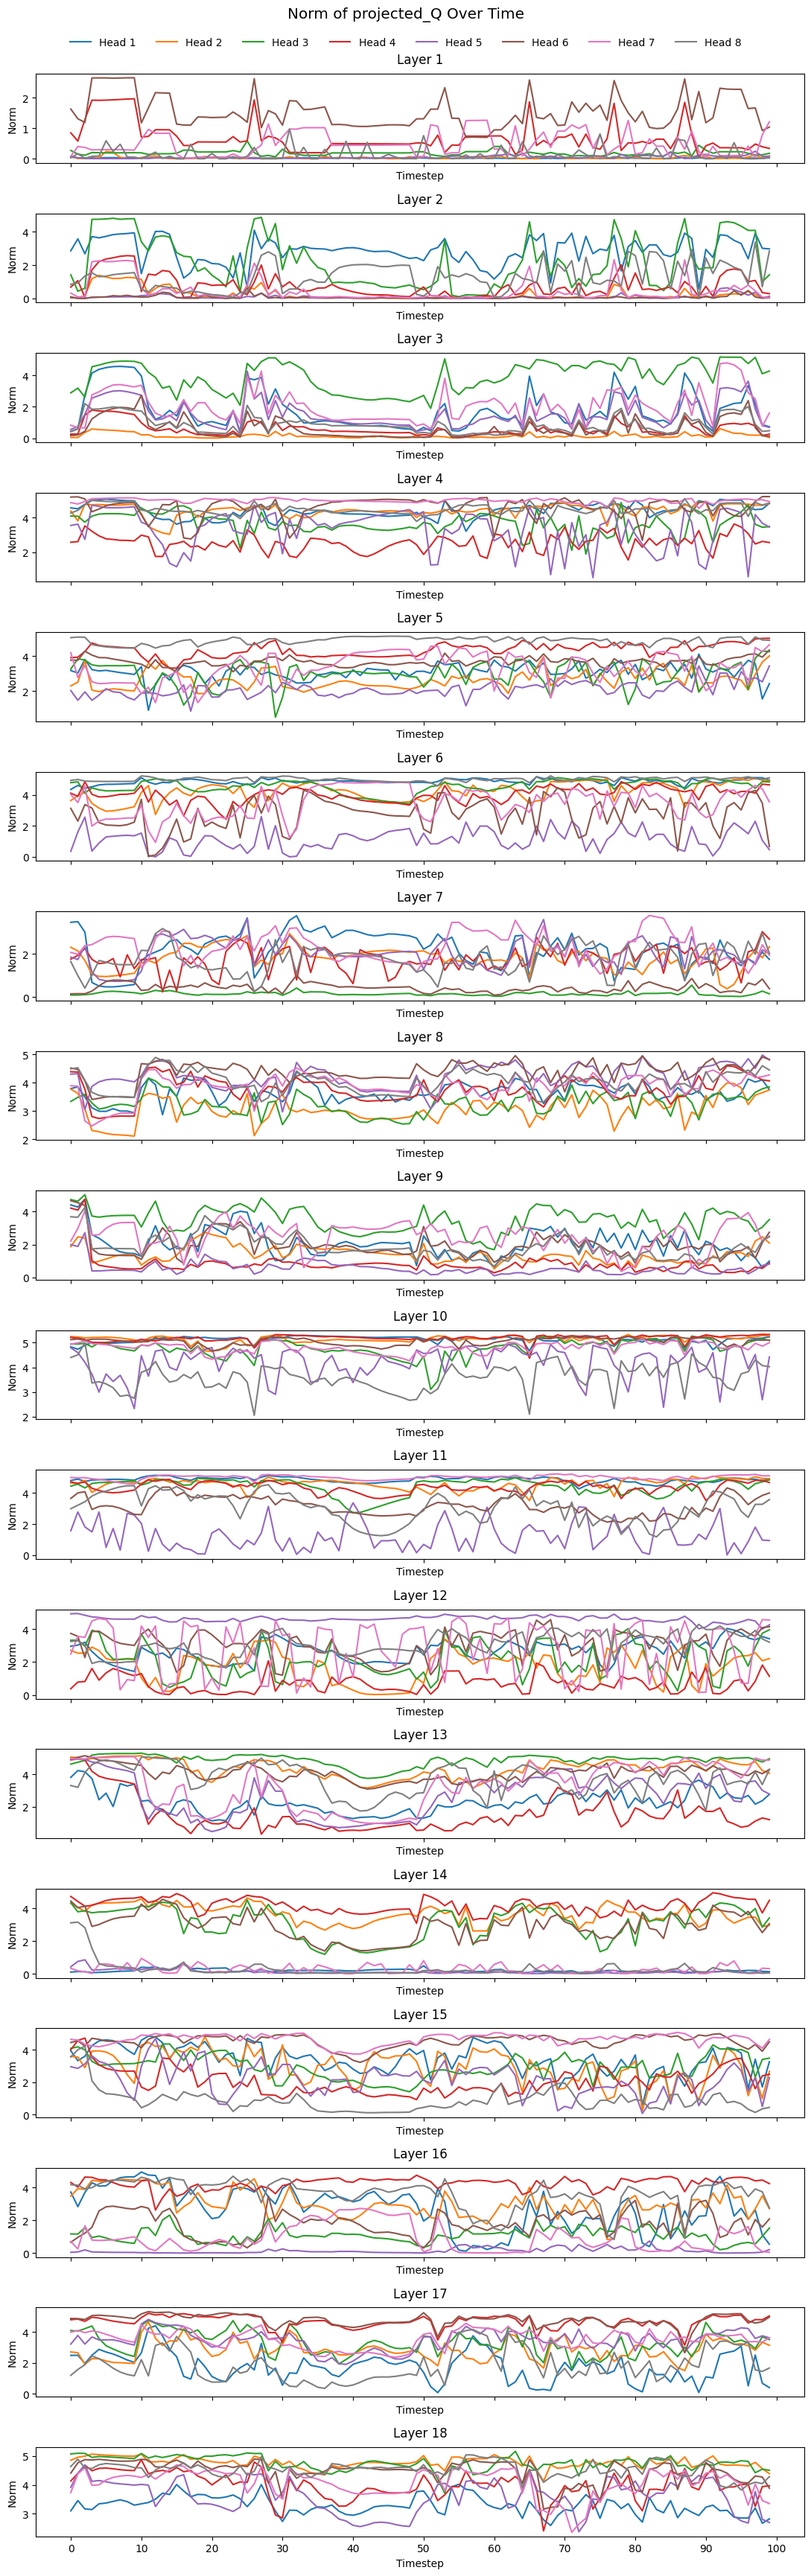

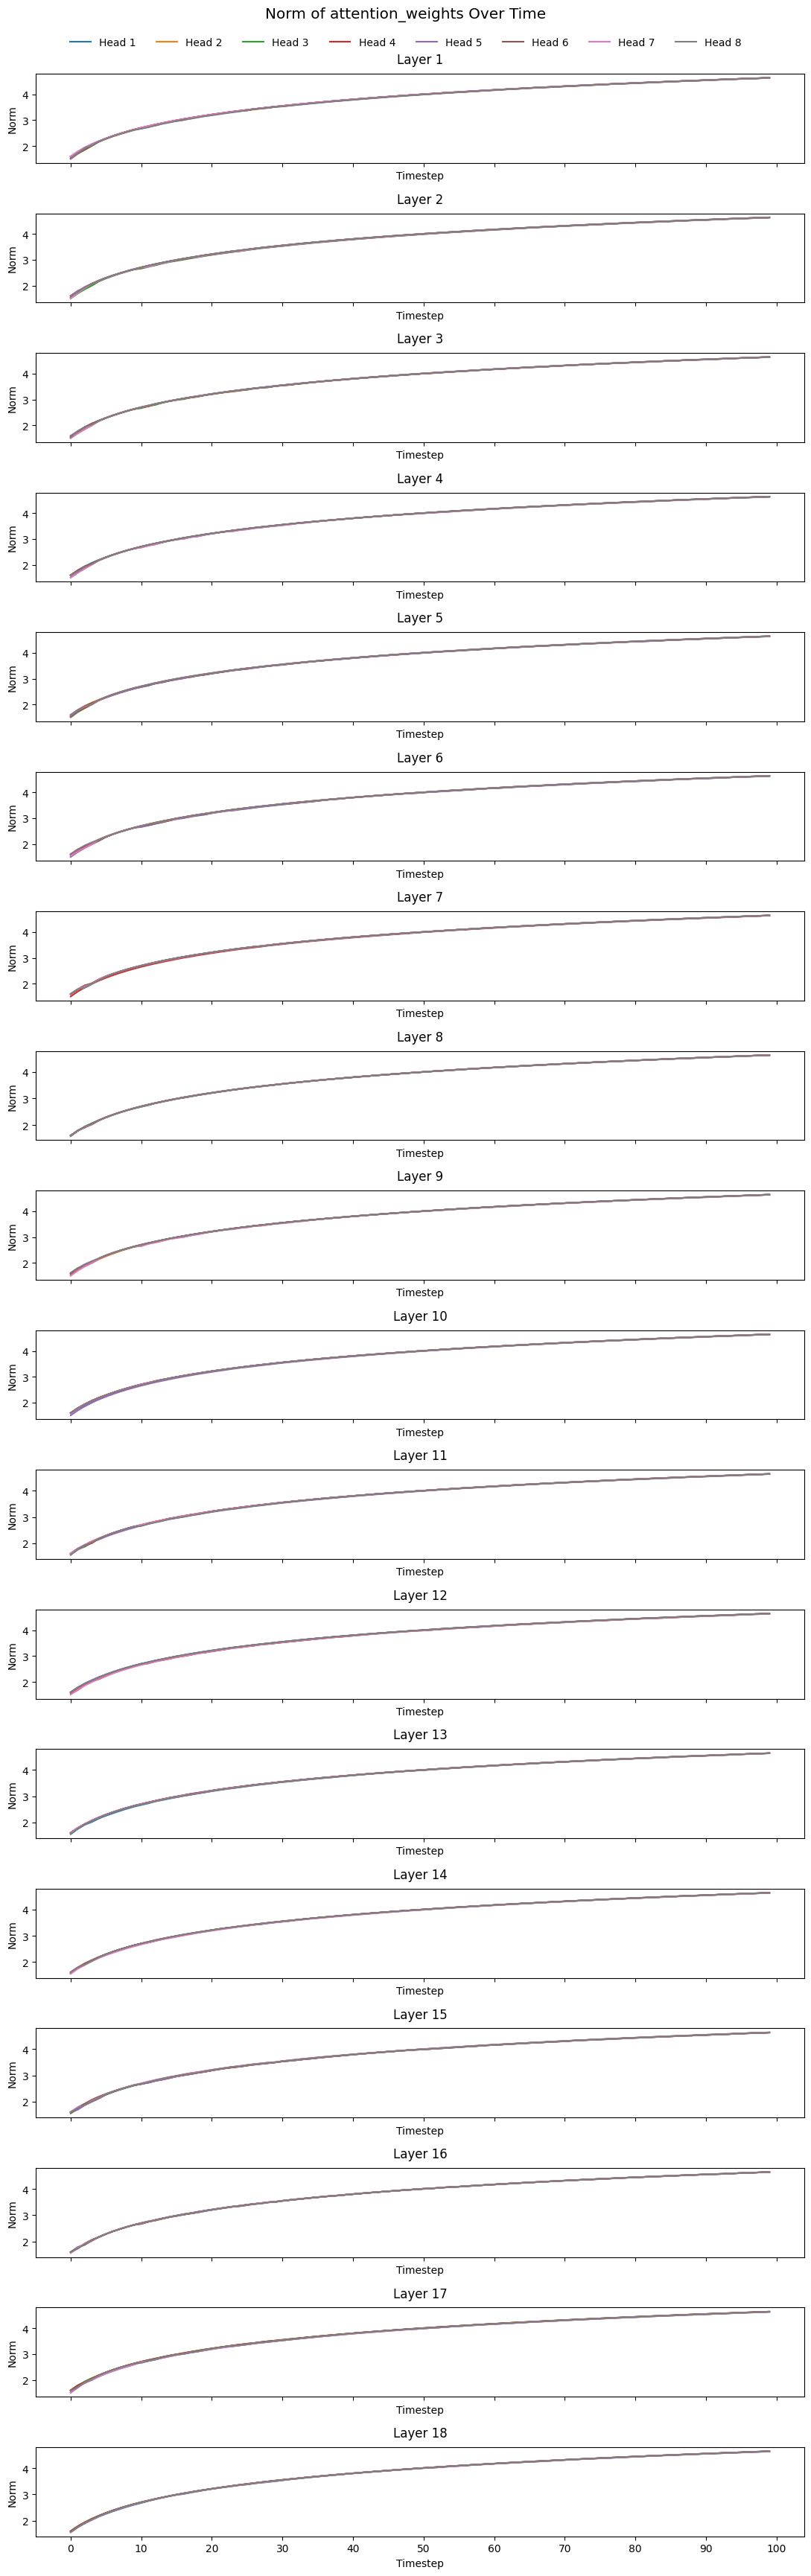

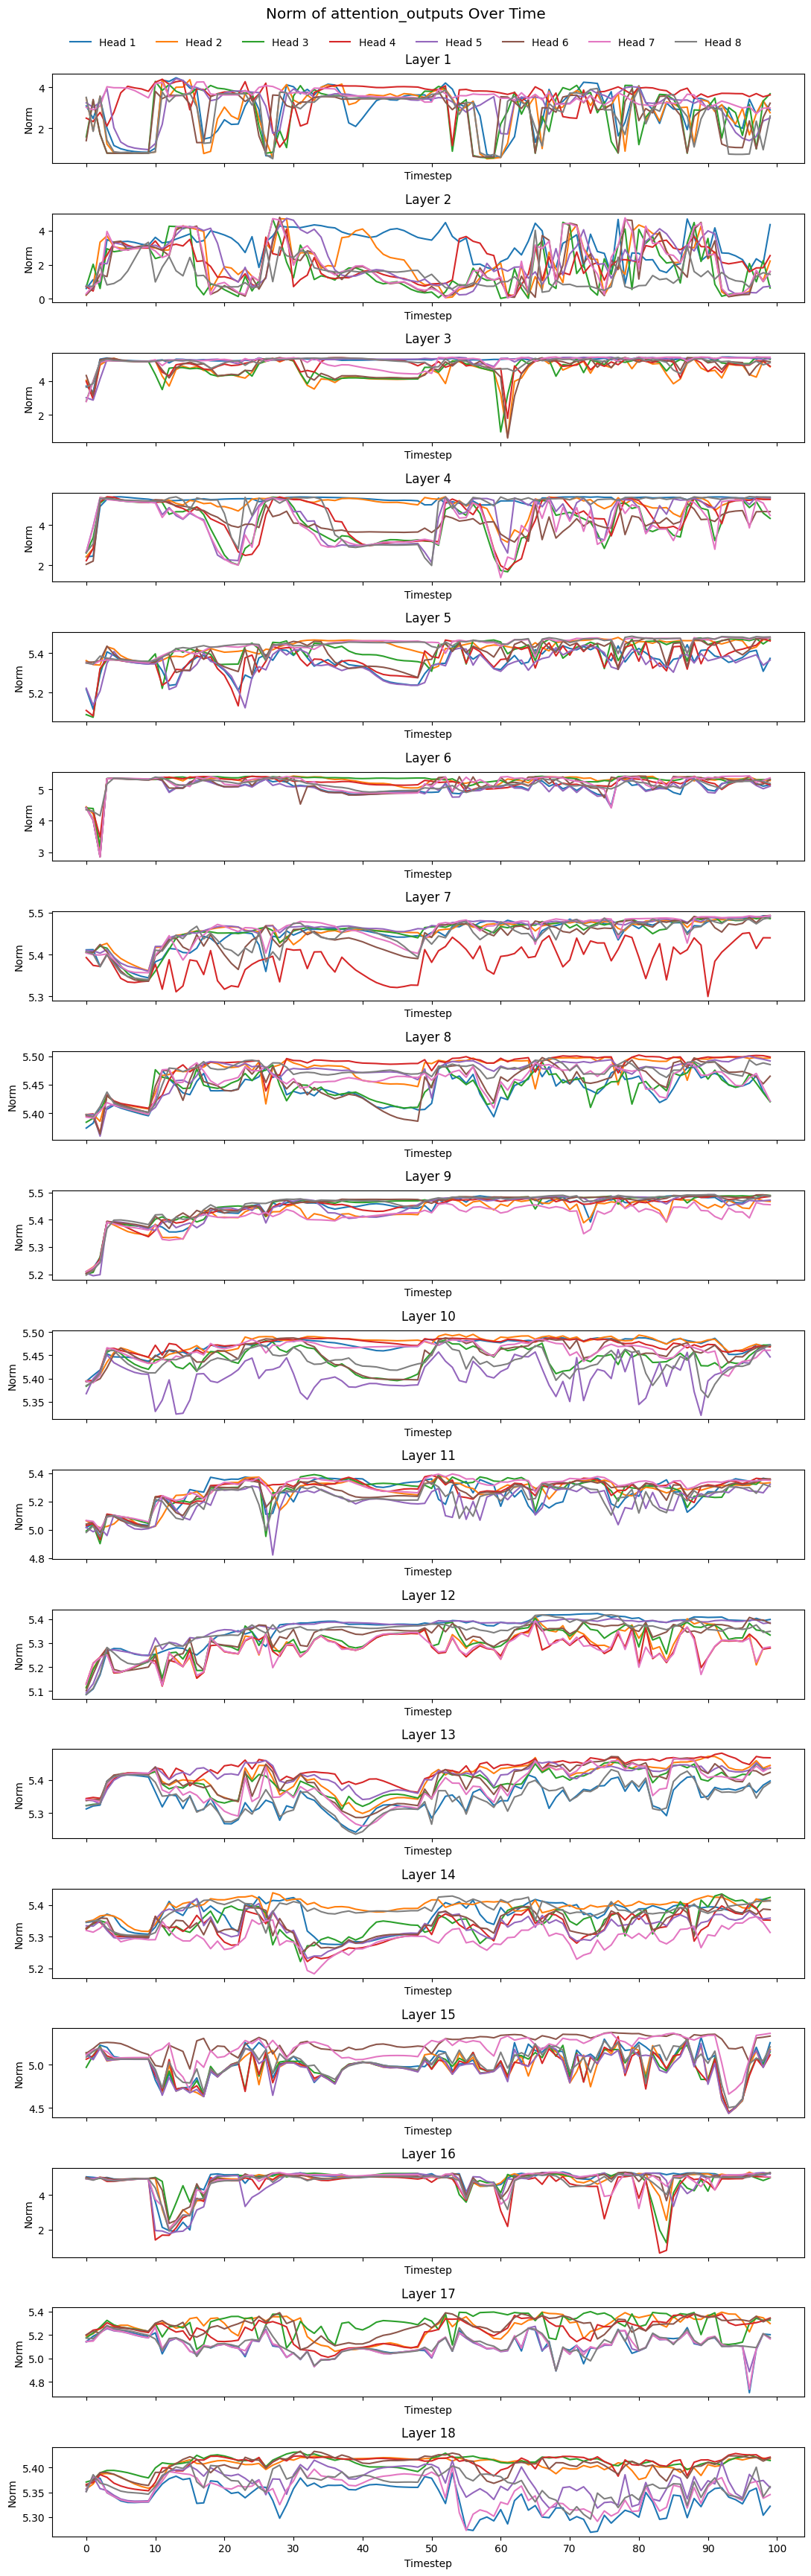

Generated Text:  mvwildằ dumSalida vector! SwitchSwitchEnterEnterEnter enter divert divert hire hire hire hire hire scroll hire DONOR проходит它 就gebietemedicinemedicineboatboatboatboat boat boat boat boat boat boat boat boat boat boat boat boat hire hire考 คร будин happen happen get get get get release release crashفة 禁作業 וה kalite меди меди你medi你 세계策略 انتخاب totها评价чеб great pretty pretty refuseткаには schlug danced相談 söyledi söyledi söyledi söyledi gobern为啥藉сса这是


In [ ]:
random_input_length, num_tokens_to_generate, temperature = 5, 100, 2

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, 
                                                                    random_input_length=random_input_length)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='mean')
# save_time_series(time_series)
plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, save=False)

print(f'Generated Text: {generated_text}')

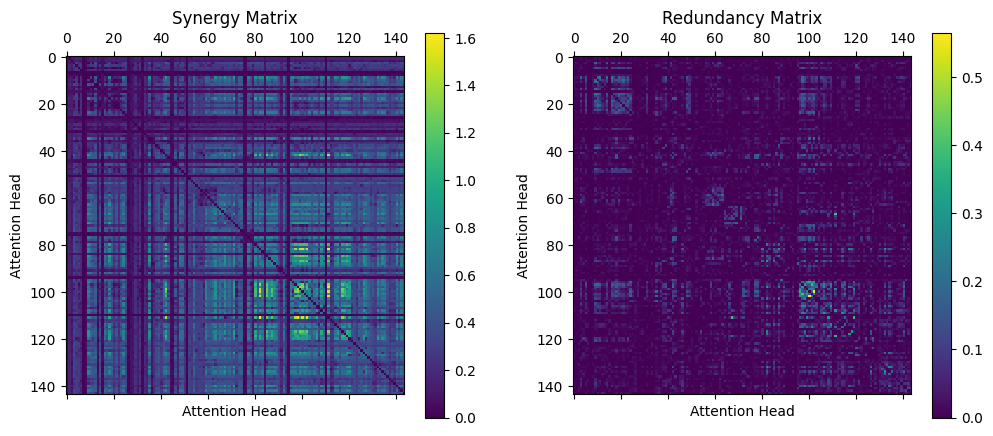

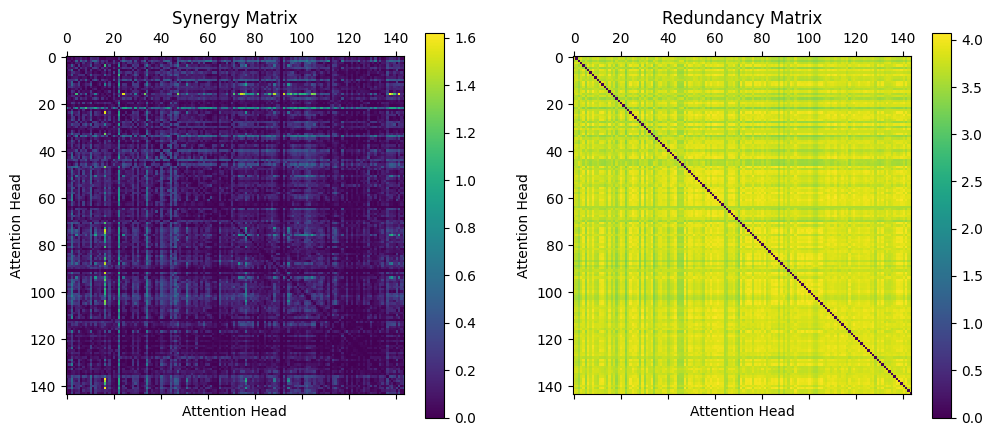

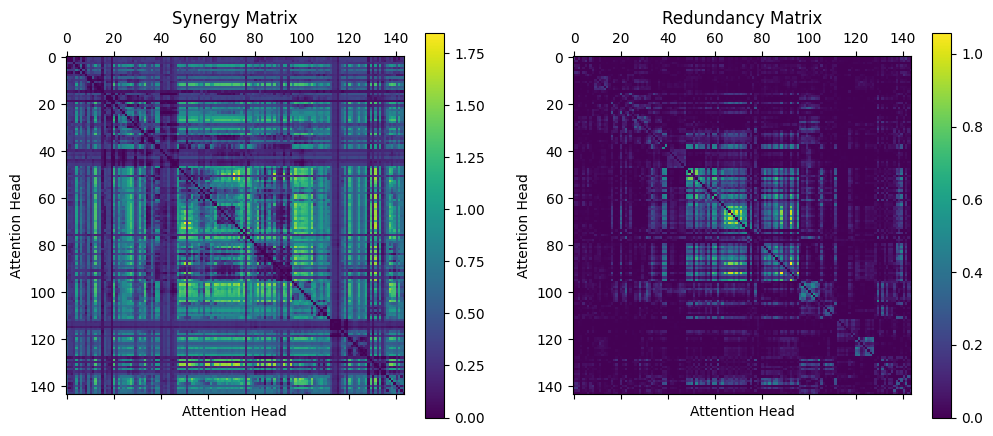

In [22]:
global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER, save=False, kind="gaussian")
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=False)

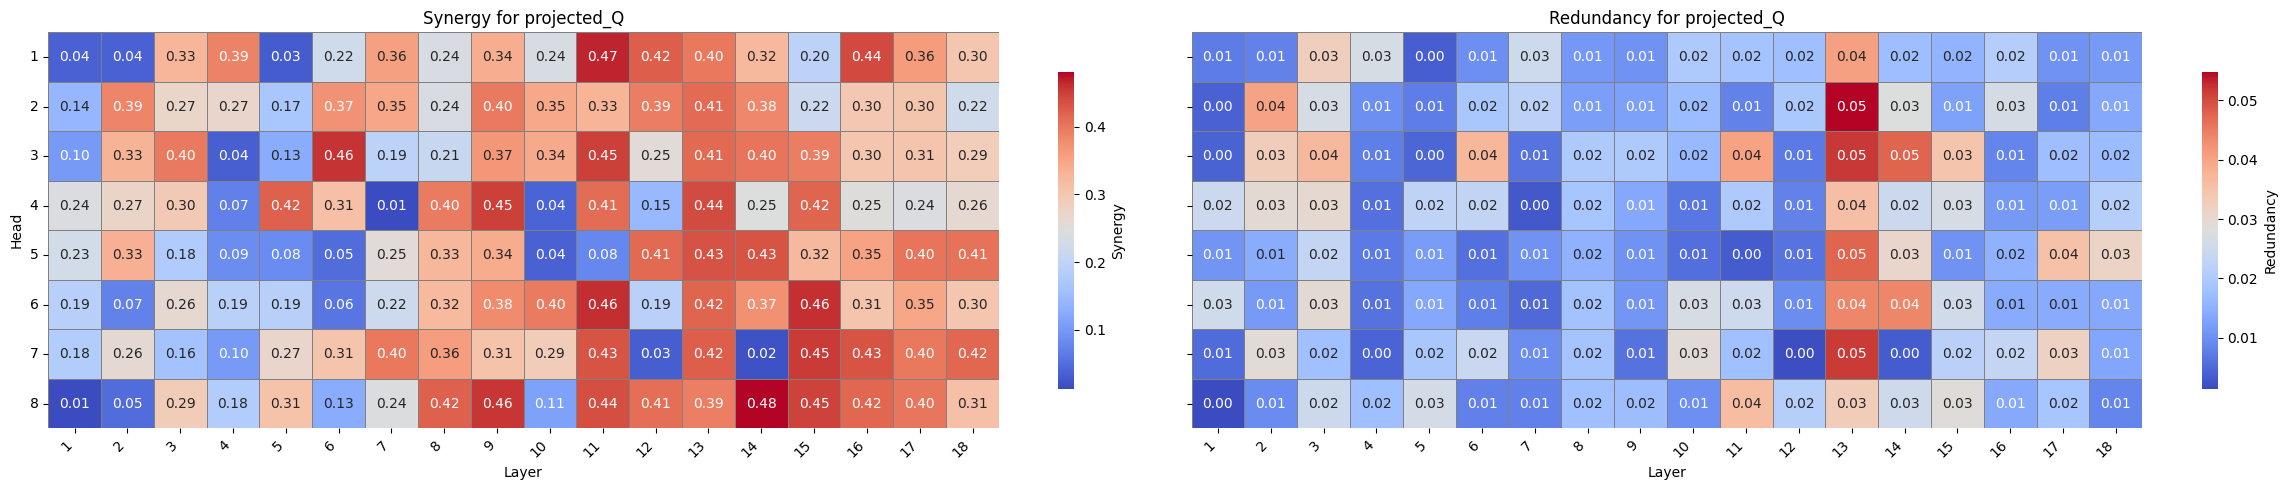

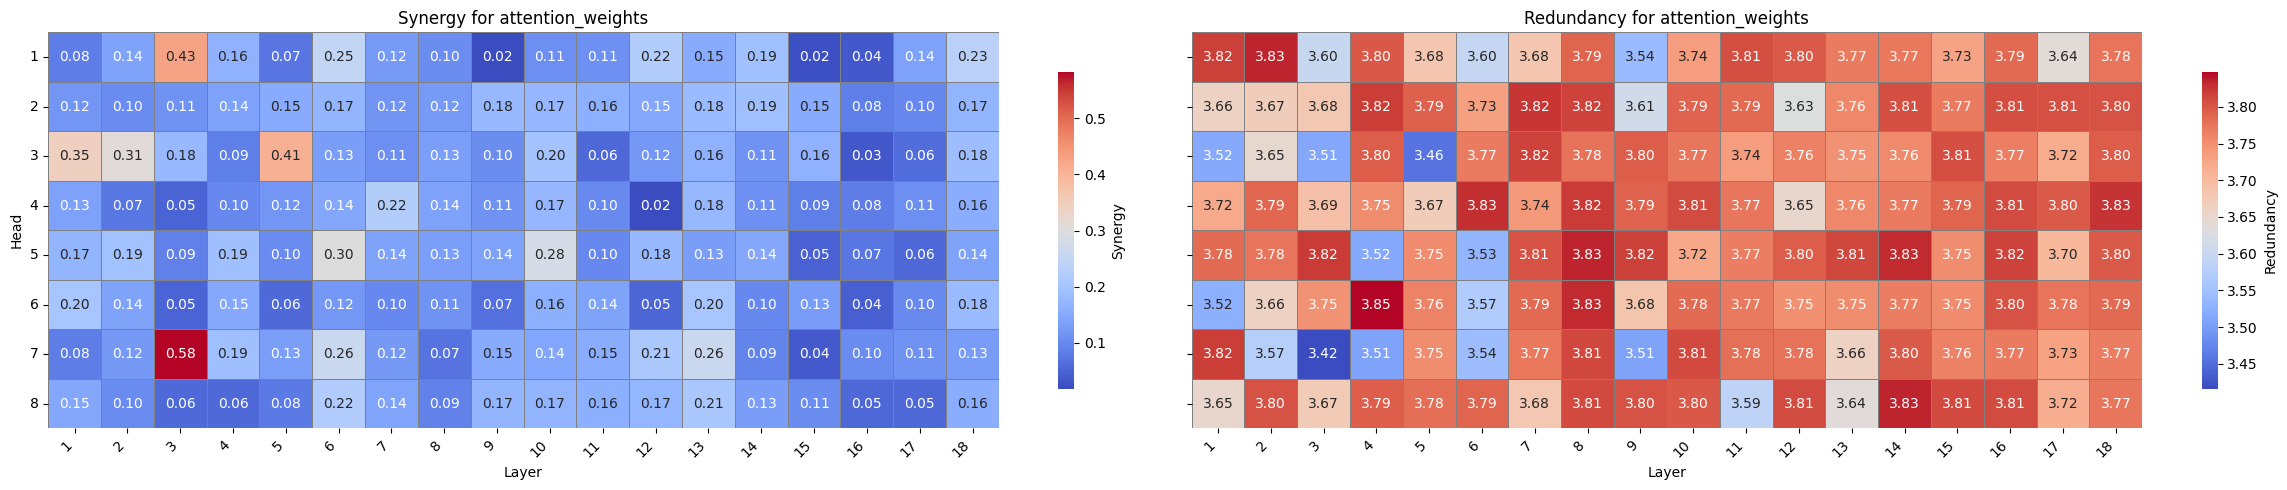

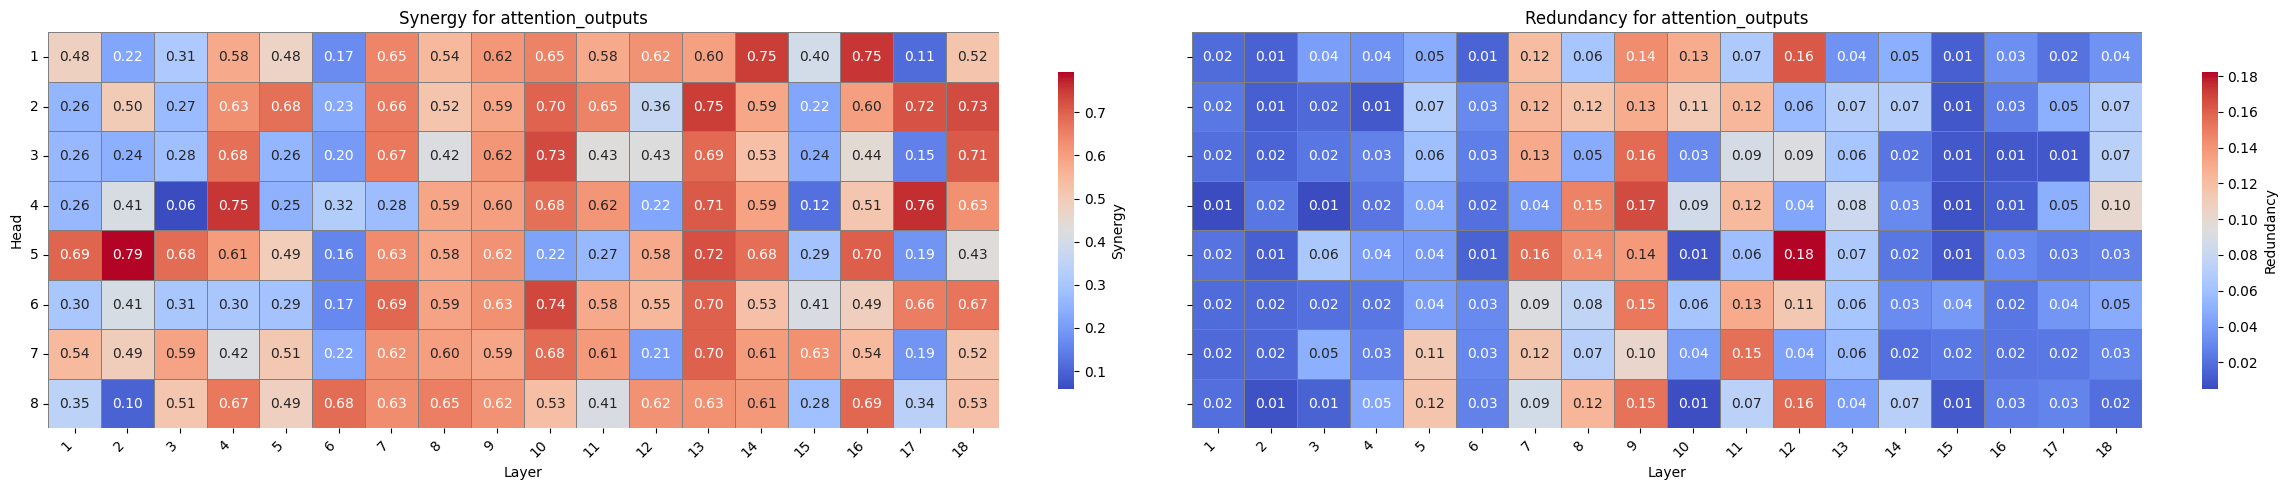

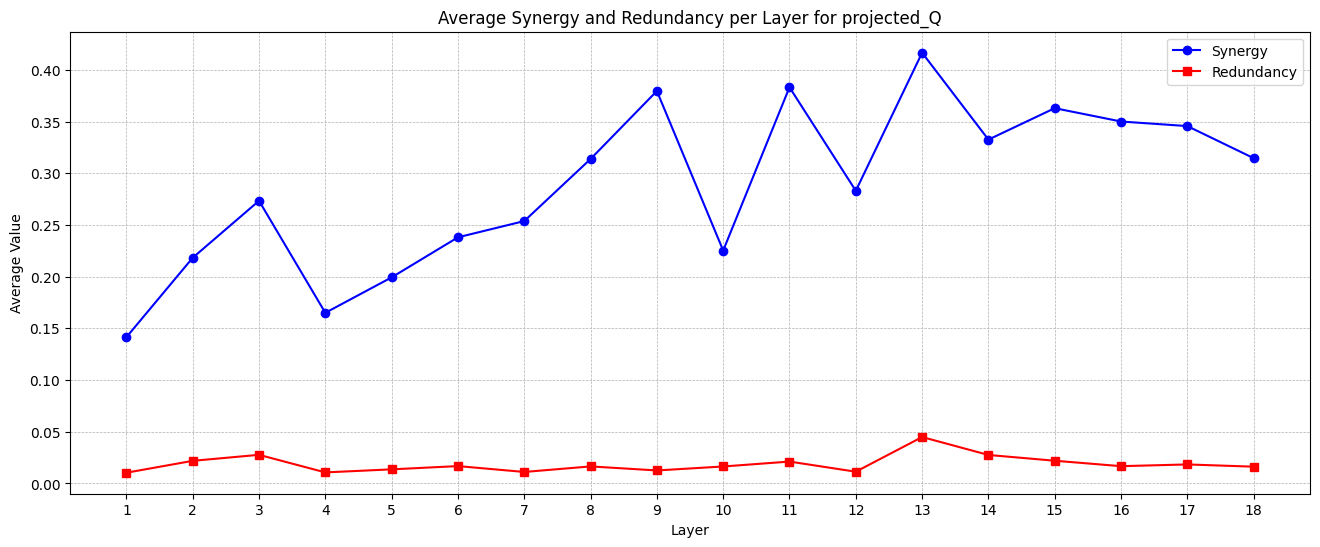

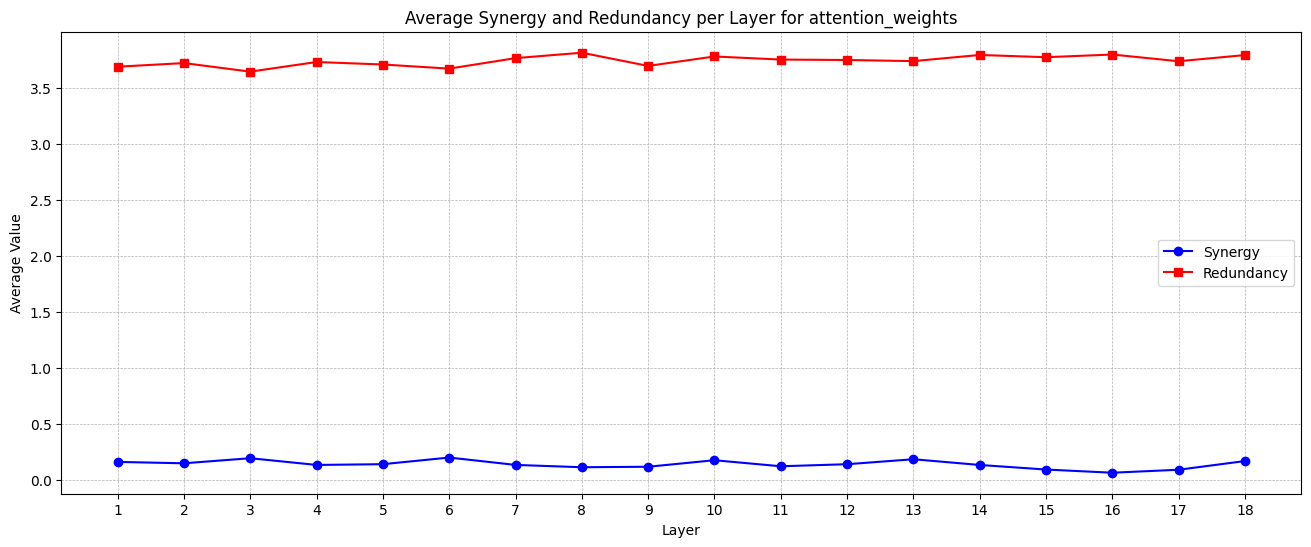

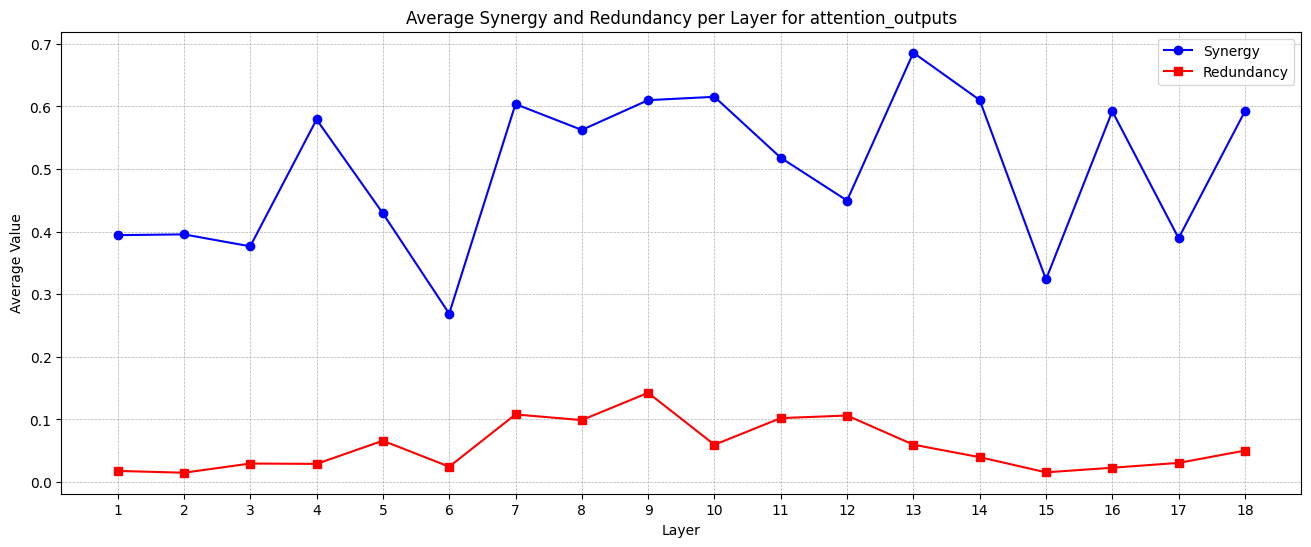

In [23]:
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=False, use_heatmap=True)
plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

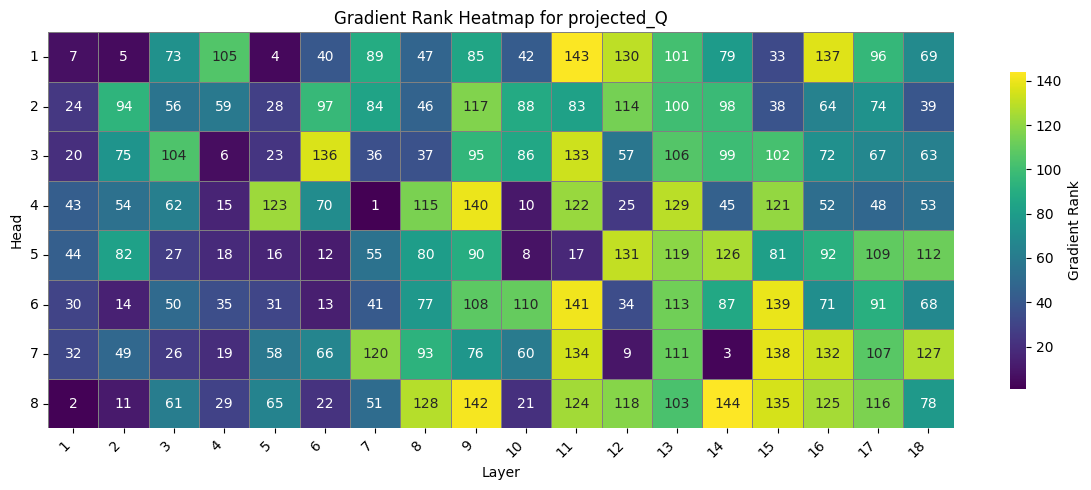

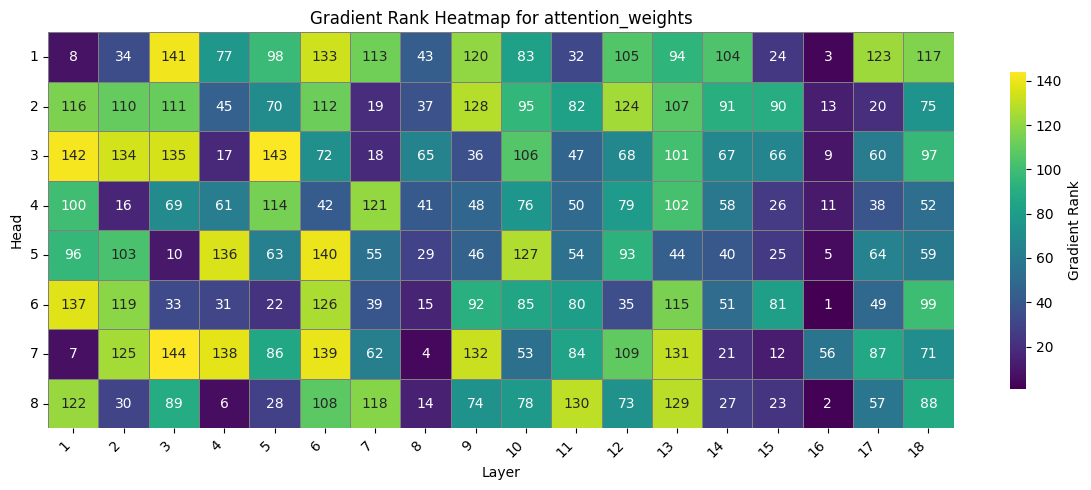

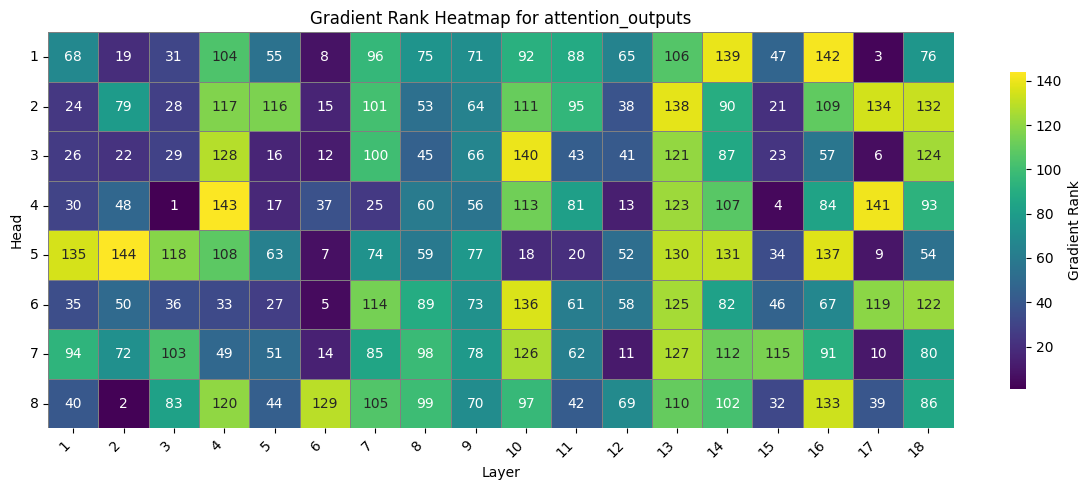

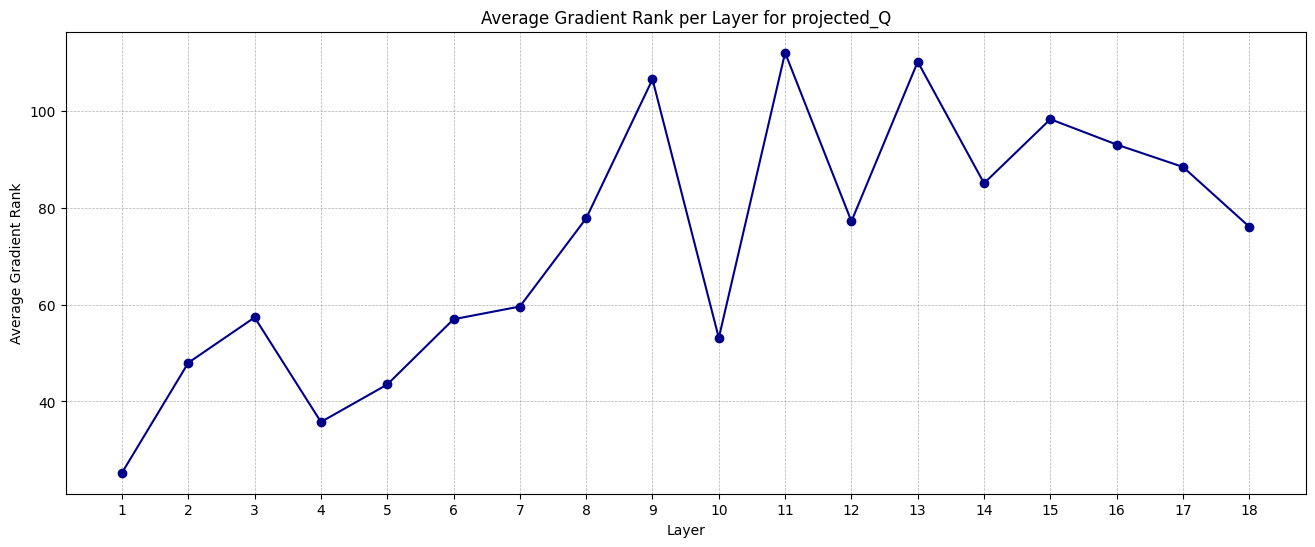

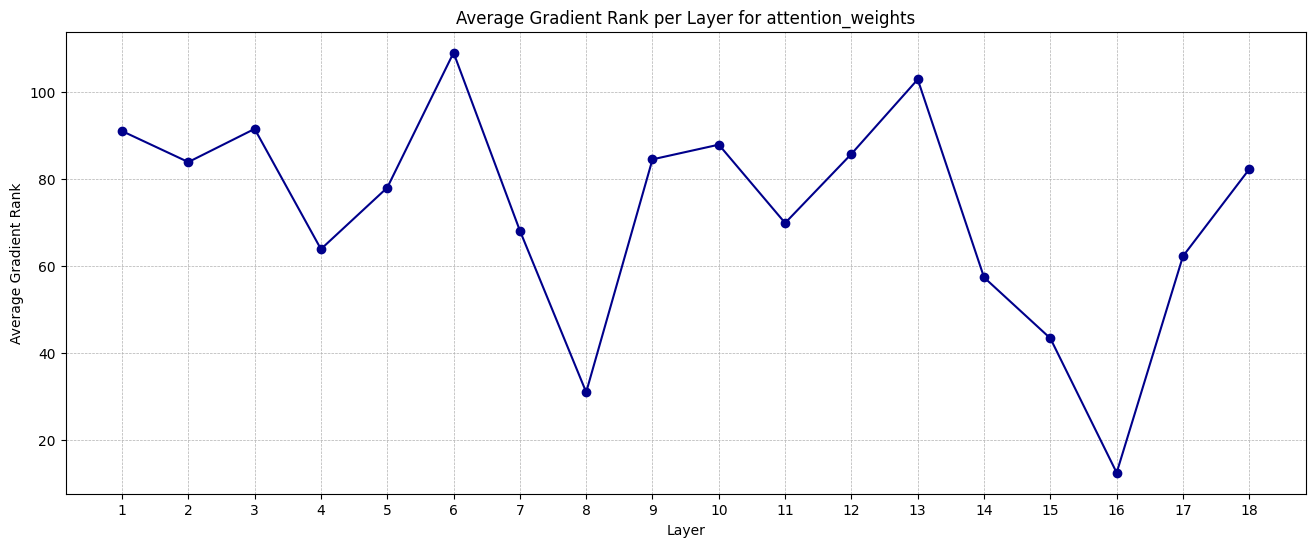

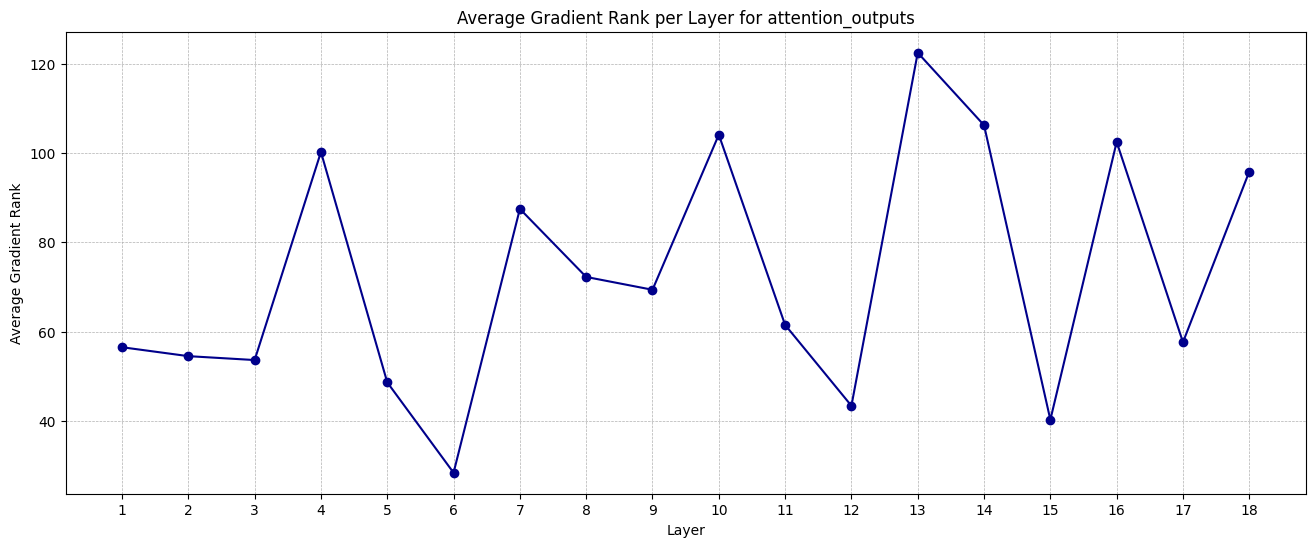

In [24]:
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=None, save=False, use_heatmap=True)
plot_average_ranks_per_layer(gradient_ranks, save=False, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

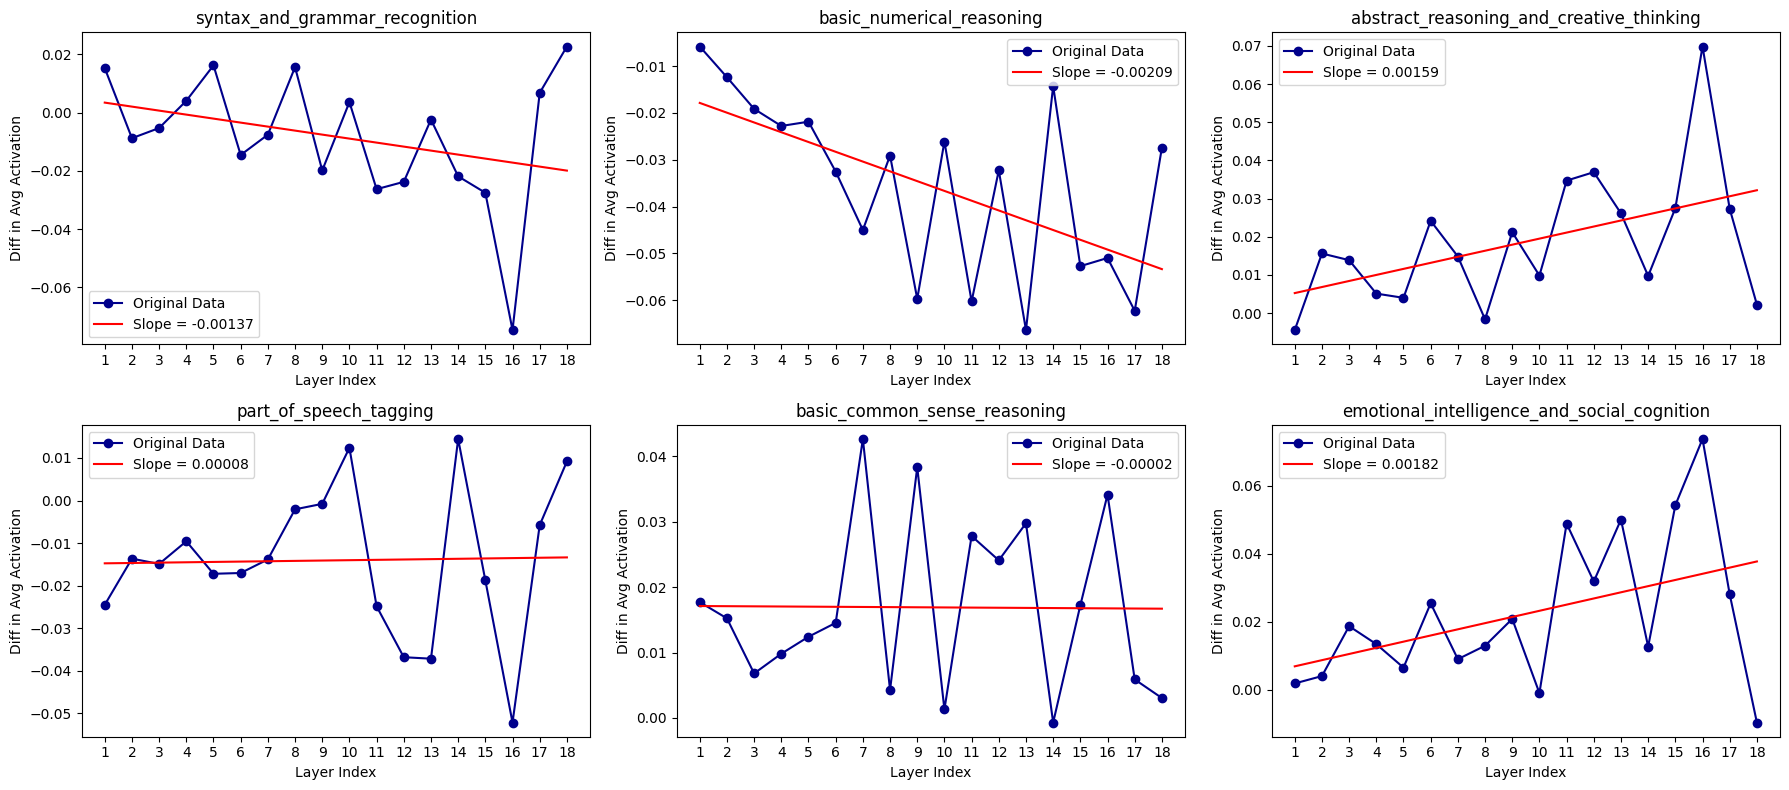

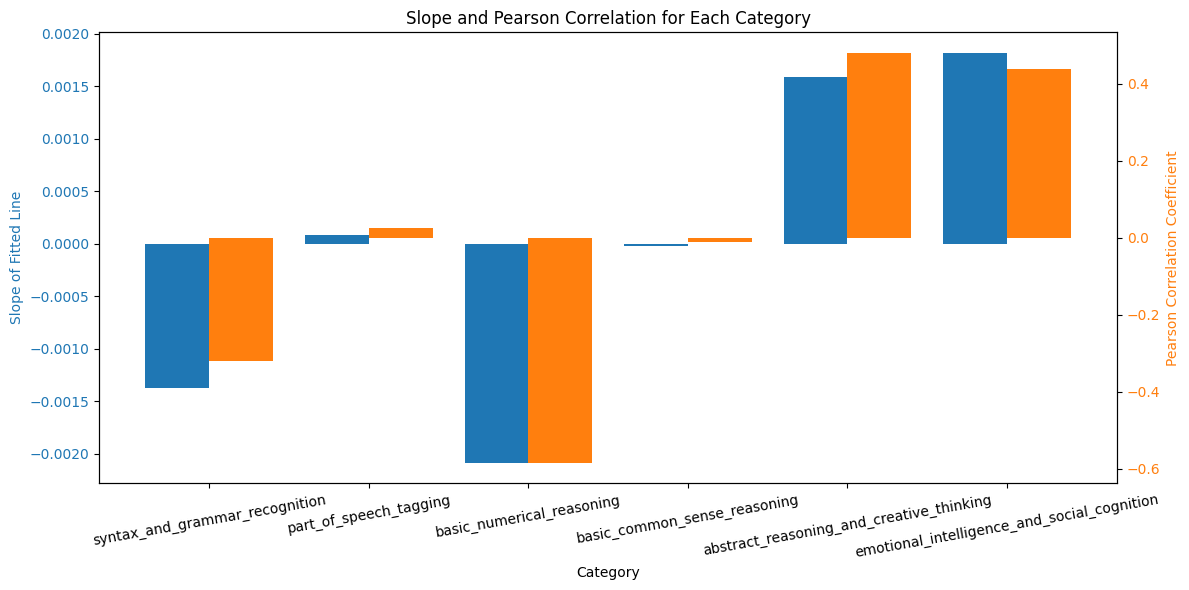

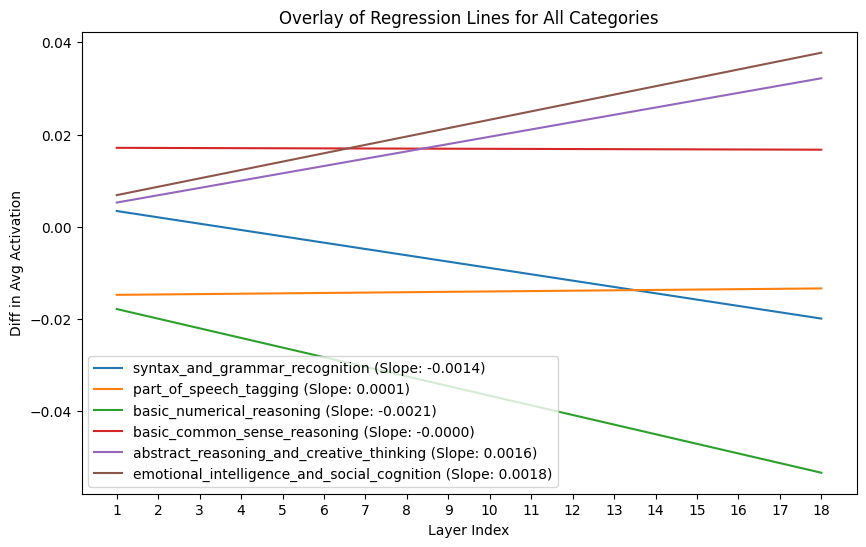

In [25]:
plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], rest_category_prefix='rest', 
                                             save=False, reorder=False, mean_instead_of_rest=True, per_layer=True)

In [23]:
for aggregation_type in ['norm', 'entropy', 'max']:
    print(f"Aggregation Type: {aggregation_type}")
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type=aggregation_type)
    global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER)
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices)
    compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=True)

Aggregation Type: norm


glob_eff_syn bigger than glob_eff_red for projected_Q: True
Global Efficiency for Synergy Matrix (projected_Q): 0.19462319388284136, Global Efficiency for Redundancy Matrix (projected_Q): 0.1264881807667149
glob_eff_syn bigger than glob_eff_red for attention_weights: True
Global Efficiency for Synergy Matrix (attention_weights): 0.17606021831782495, Global Efficiency for Redundancy Matrix (attention_weights): 0.11923932685586566
glob_eff_syn bigger than glob_eff_red for attention_outputs: True
Global Efficiency for Synergy Matrix (attention_outputs): 0.1882461751238846, Global Efficiency for Redundancy Matrix (attention_outputs): 0.10530406681497179
modularity_redundancy bigger than modularity_synergy for projected_Q: True
Modularity of Synergy Matrix (projected_Q): 0.08579350833363253, Modularity of Redundancy Matrix (projected_Q): 0.194661321013693
modularity_redundancy bigger than modularity_synergy for attention_weights: True
Modularity of Synergy Matrix (attention_weights): 0.0604

### Generate Several Time Series, Plot and Save them

In [ ]:
num_time_series = 1
random_input_length, num_tokens_to_generate, temperature = 24, 100, 0.3
prompt = constants.prompts_2["basic_numerical_reasoning"][0]

for n_time_series in range(num_time_series):
    print(f"Time Series {n_time_series + 1}/{num_time_series}")
    generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
    save_time_series(time_series)
    plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, save=False)

    print(f'Generated Text: {generated_text}')

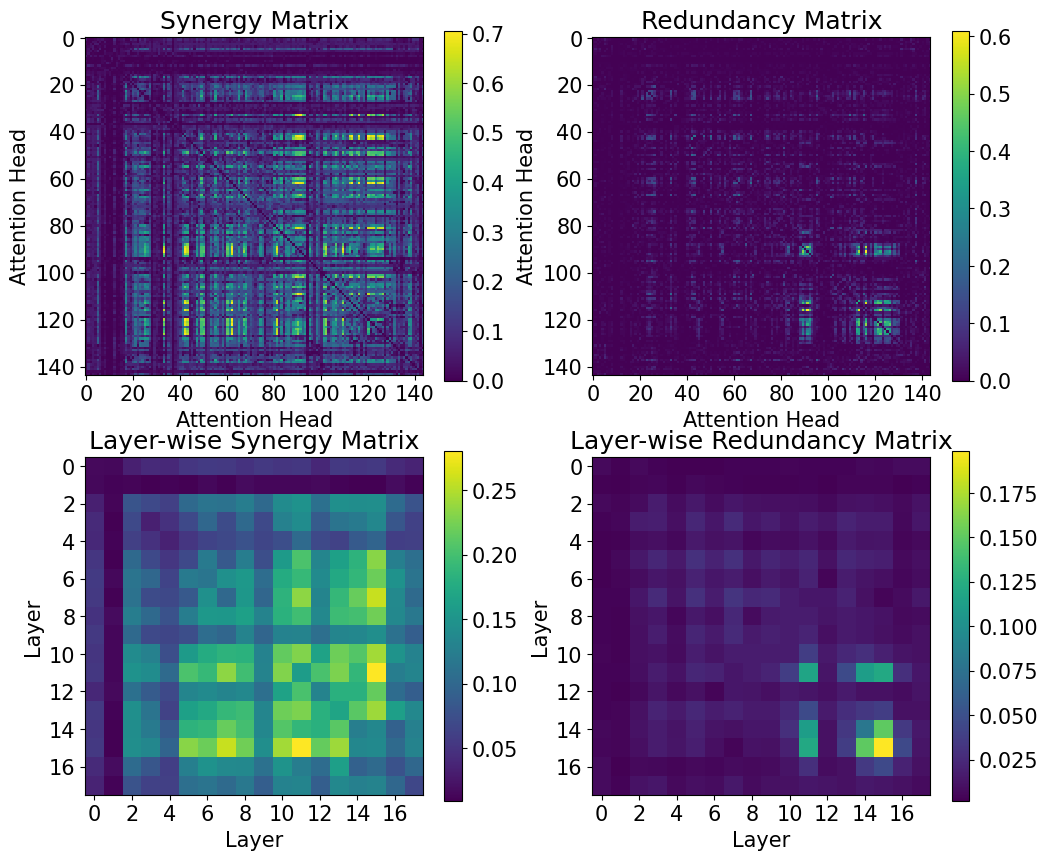

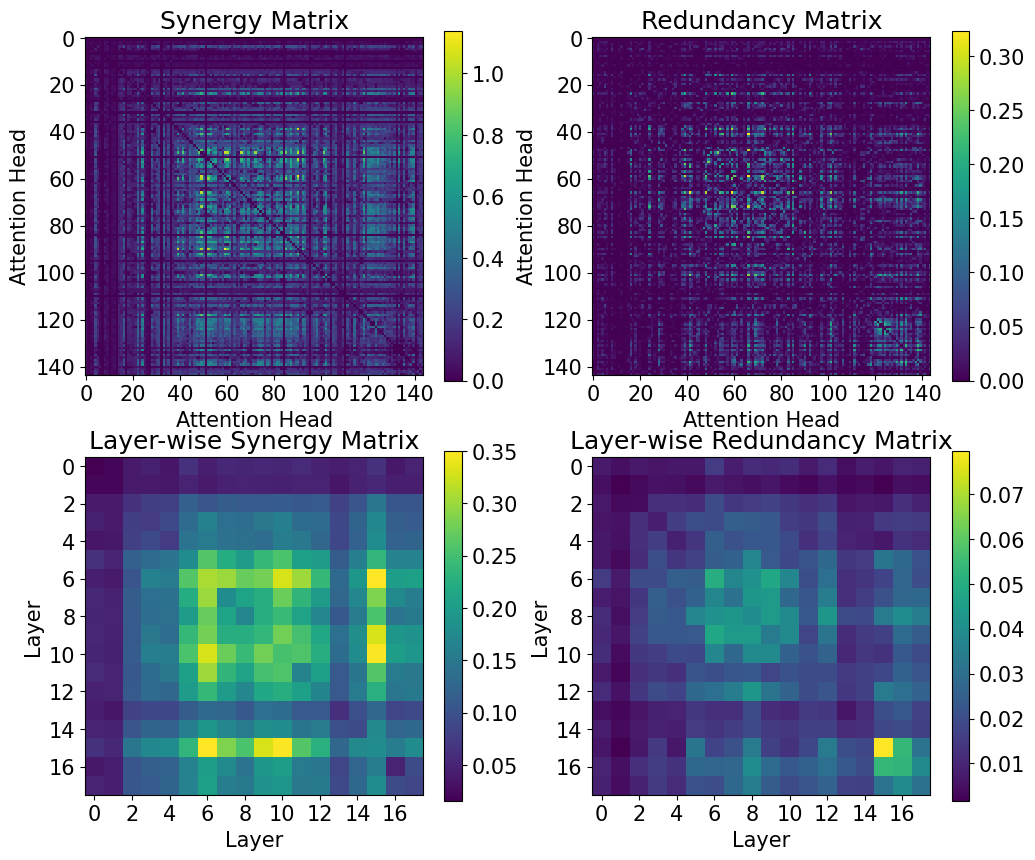

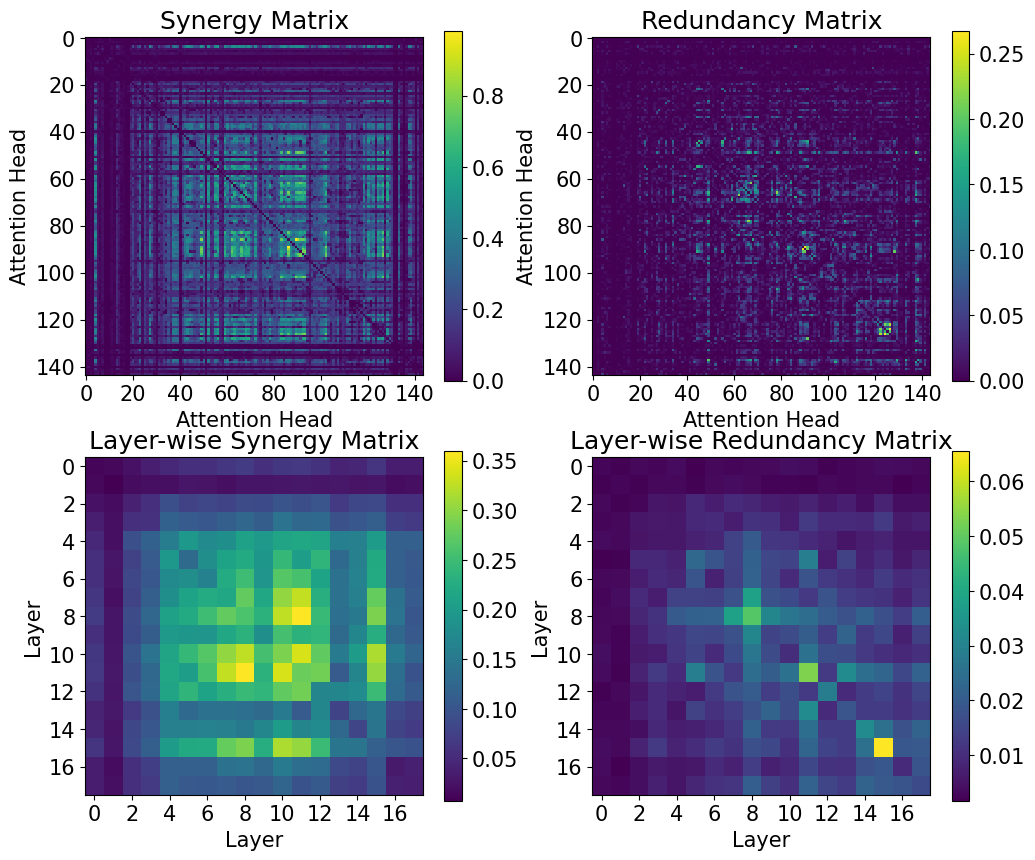

In [ ]:
global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER, save=True, kind="gaussian")
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=False)

### Generate Time Series using Prompts

In [8]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 0.3
time_series = {}

for cognitive_task in constants.prompts_2.keys():
    print("Cognitive Task: ", cognitive_task)
    prompt = constants.prompts_2[cognitive_task][0]
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
        temperature=temperature, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
    time_series[cognitive_task] = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
    save_time_series(time_series[cognitive_task], base_plot_path=constants.TIME_SERIES_DIR+cognitive_task+".pt")
    plot_attention_metrics_norms_over_time(time_series[cognitive_task], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, save=True,
                                           base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/")
    print(f'Generated Text for {cognitive_task}: {generated_text}')

Cognitive Task:  syntax_and_grammar_recognition
Generated Text for syntax_and_grammar_recognition: Correct the error: He go to school every day.

**Corrected:** He goes to school every day.

**Explanation:**
In this sentence, the subject is "he," which is a singular pronoun. Therefore, the correct verb form is "goes."**Note:**
The incorrect sentence "He go to school every day" is grammatically incorrect. It should be "He goes to school every day."**Additional Tips:**
* Remember that the singular verb forms are "goes," "says," "writes," etc.

Cognitive Task:  part_of_speech_tagging
Generated Text for part_of_speech_tagging: Identify the parts of speech in the sentence: Quickly, the agile cat climbed the tall tree.

**Results:**

* Quickly - Adverb
* The - Definite article
* Agile - Adjective
* Cat - Noun
* Climbed - Verb
* The - Definite article
* Tall - Adjective
* Tree - Noun


**Explanation:**

* **Adverbs:** Quickly and the are adverbs that modify the verb climbed.
* **Adjectives:**

In [35]:
all_matrices, synergy_matrices, redundancy_matrices = {}, {}, {}
for cognitive_task in list(constants.prompts_2.keys()):
    print(cognitive_task)
    all_matrices[cognitive_task], synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task] = compute_PhiID(time_series[cognitive_task],
                save=True, kind="gaussian", base_save_path=constants.MATRICES_DIR+cognitive_task+'.pt')
    plot_synergy_redundancy_PhiID(synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task], save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR+cognitive_task+"/")

basic_numerical_reasoning
Calculating PhiID for metric: projected_Q
Calculating PhiID for head 0...
Calculating PhiID for head 50...
Calculating PhiID for head 100...
Calculating PhiID for head 150...
Calculating PhiID for head 200...
Calculating PhiID for head 250...
Calculating PhiID for head 300...
Calculating PhiID for head 350...
Calculating PhiID for head 400...
Calculating PhiID for metric: attention_weights
Calculating PhiID for head 0...
Variance for head 4 was zero. Modified element at index 30.
Calculating PhiID for head 50...
Calculating PhiID for head 100...
Calculating PhiID for head 150...
Calculating PhiID for head 200...
Calculating PhiID for head 250...
Calculating PhiID for head 300...
Calculating PhiID for head 350...
Calculating PhiID for head 400...
Calculating PhiID for metric: attention_outputs
Calculating PhiID for head 0...
Calculating PhiID for head 50...
Calculating PhiID for head 100...
Calculating PhiID for head 150...
Calculating PhiID for head 200...
Cal

In [8]:
all_matrices, synergy_matrices, redundancy_matrices = {}, {}, {}
for cognitive_task in constants.prompts_2.keys():
    base_save_path = constants.MATRICES_DIR+cognitive_task+'.pt'
    all_matrices[cognitive_task], synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task] = load_matrices(base_save_path=base_save_path)

In [ ]:
all_matrices, synergy_matrices, redundancy_matrices = average_synergy_redundancies_matrices_cognitive_tasks(all_matrices, synergy_matrices, redundancy_matrices)
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=False, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + "mean_cognitive_tasks/")

In [12]:
save_matrices(all_matrices, synergy_matrices, redundancy_matrices, base_save_path=constants.MATRICES_DIR + 'average_prompts' + '.pt')